In [1]:
from scipy import *
from qutip import *
from matplotlib import *
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib import cm

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

In [24]:
#parametrs
n = 100
e = 1.6e-19
Fi0 = 2e-15

fr = 6e9
g = 50e9 # coupling stranght
M = 2*pi*1e11

C_J = 90e-15
C_sh = 90e-15
C_tot = C_J + C_sh
OmQ = 5.3e6

E_C = 200e6 # e*e/(2*C_tot)
alpha = -1*E_C #anharmonicity

Current = np.linspace(-1e-4, 1e-4, n)
Frequency = np.linspace(4.99e9, 8.01e9, n)
E_J = np.zeros(n)
E_J_max = (5.3e6+E_C)*(5.3e6+E_C)/(8*E_C)
omegaP = np.zeros(n) #плазменная частота 
omegaEG = np.zeros(n) # частота перехода кубита
Delta = np.zeros(n) # отстройка частоты кубита от частоты резонатора
Chi = np.zeros(n) #dispersive shift


for i in range(0,n):
    Fi = Current[i]*M
    E_J[i] = abs(E_J_max*np.cos(Fi/Fi0))
    omegaP[i] = sqrt(8*E_C*E_J[i]) 
    omegaEG[i] = omegaP[i] - E_C
    Delta[i] = np.abs(2*pi*Frequency[i] - omegaEG[i])
    Chi[i] = g*g/Delta[i]

In [17]:
a = (5.3e6+200e6)
a = a*a
a = a/8/(200e6)
a

26342556.25

S-параметр резонатора: 

$S_{21} = a e^{i\alpha} e^{-2\pi i f \tau} \bigg[1 - \frac{(Q_{l}|Q_{c}|)e^{i\phi}}{1 + 2iQ_{l}(f/f_{r}-1) } \bigg]$

Here, f denotes  theprobe  frequency, $f_{r}$ the  resonance  frequency, $Q_{l}$ the loaded and |$Q_{c}$| the absolute value of the coupling quality factor and $\phi$ quantifies the impedance mismatch. The environment is  accounted  for  by  adding  an  additional amplitudea, a phase shift $\alpha$ and the electronic delay $\tau$
caused by the length of the cable and finite speed of light.

f - частота 1 тона, подаваемыйй сигнал, зависимость его от S

$f_{r}$ - резонансная частота резонатора

In [22]:
Ql = 3e3
Qc = 2.9e3

#alpha = 0.
tau = 0. #10.**(-10)
phi = 0.
a = 1.

def fS21(f, Current): 
    A = a * exp(1j * alpha) * exp(-2*pi*1j*f*tau)
    Qdel = (Ql/abs(Qc))*exp(1j*phi)
    fdel = f/fr - 1
    Z = 1+2*1j*Ql*fdel
    ideal = 1 - Qdel/Z
    fS21 = A*ideal
    return fS21

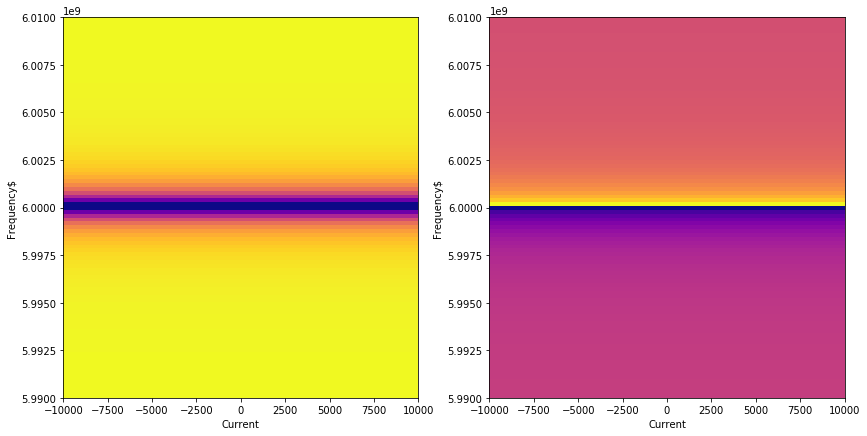

In [8]:
#pure resonator
S21 = np.zeros((n,n))

XX, YY = np.meshgrid(Frequency, Current)

S21abs_r = np.abs(fS21(XX,YY))
S21arg_r = np.angle(fS21(XX,YY))

fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)    
fig.set_figheight(7)  

ax[0].set_xlabel('Current')
ax[0].set_ylabel('Frequency$')
ax[1].set_xlabel('Current')
ax[1].set_ylabel('Frequency$')


ax[0].pcolormesh(Current, Frequency, S21abs_r.T, cmap='plasma')
ax[1].pcolormesh(Current, Frequency, S21arg_r.T, cmap='plasma')
#z = ax[0].colorbar()

DIspersive approximation hamiltonian:

$H = (\omega_{r} + \chi \sigma_{z})(a^{\dagger}a+\frac{1}{2}) + \frac{\omega_{q}' = \omega_{q}}{2}\sigma_{z}$

где $\chi = g^{2}/\Delta$ is the qubit-state dependent frequency shift, a socalled “dispersive shift”. 

$\omega_{q}' = \omega_{q} + \chi$ 

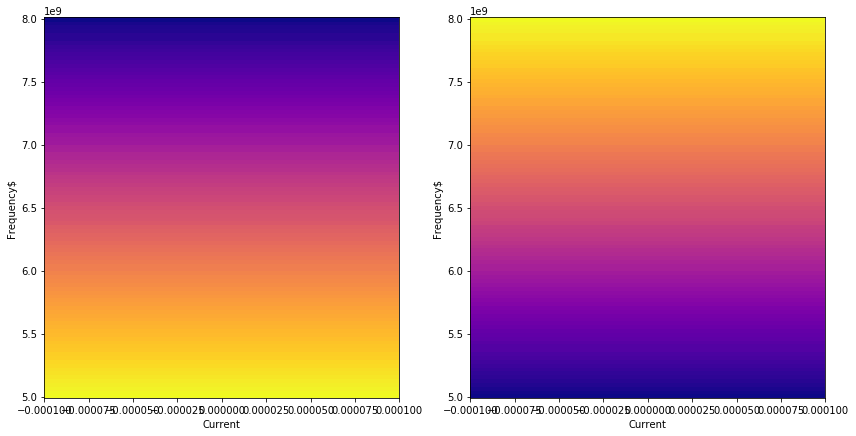

In [25]:
#resonator+qubit
Frequency_disp = np.zeros(n)
for i in range(0,n):
    Frequency_disp[i] = Frequency[i] + Chi[i]


XX_disp, YY_disp = np.meshgrid(Frequency_disp, Current)
S21abs_rq = np.abs(fS21(XX_disp,YY_disp))
S21arg_rq = np.angle(fS21(XX_disp,YY_disp))

fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)    
fig.set_figheight(7)  

ax[0].set_xlabel('Current')
ax[0].set_ylabel('Frequency$')
ax[1].set_xlabel('Current')
ax[1].set_ylabel('Frequency$')


ax[0].pcolormesh(Current, Frequency, S21abs_rq.T, cmap='plasma')
ax[1].pcolormesh(Current, Frequency, S21arg_rq.T, cmap='plasma')